統計解析用プログラミング言語Rによるコロナ感染者数の集計と予測

In [8]:
install.packages("tsibble")
install.packages("zoo")
install.packages("forecast")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’




In [9]:
library(tsibble)
library(dplyr)
library(ggplot2)
library(zoo)
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Using `day` as index variable.

Using `day` as index variable.

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


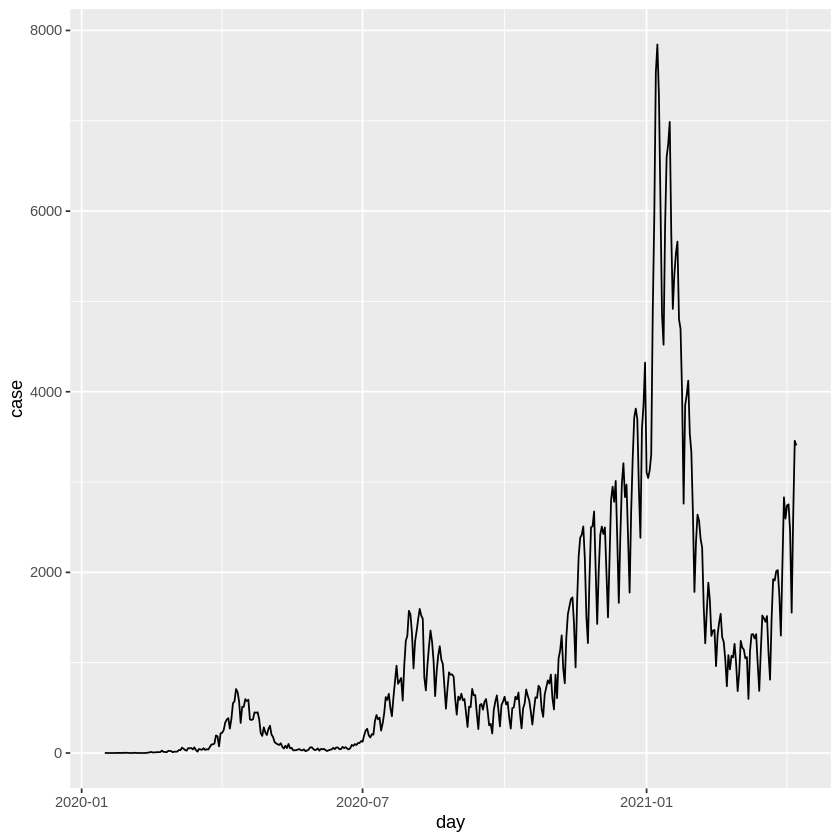

Using `day` as index variable.



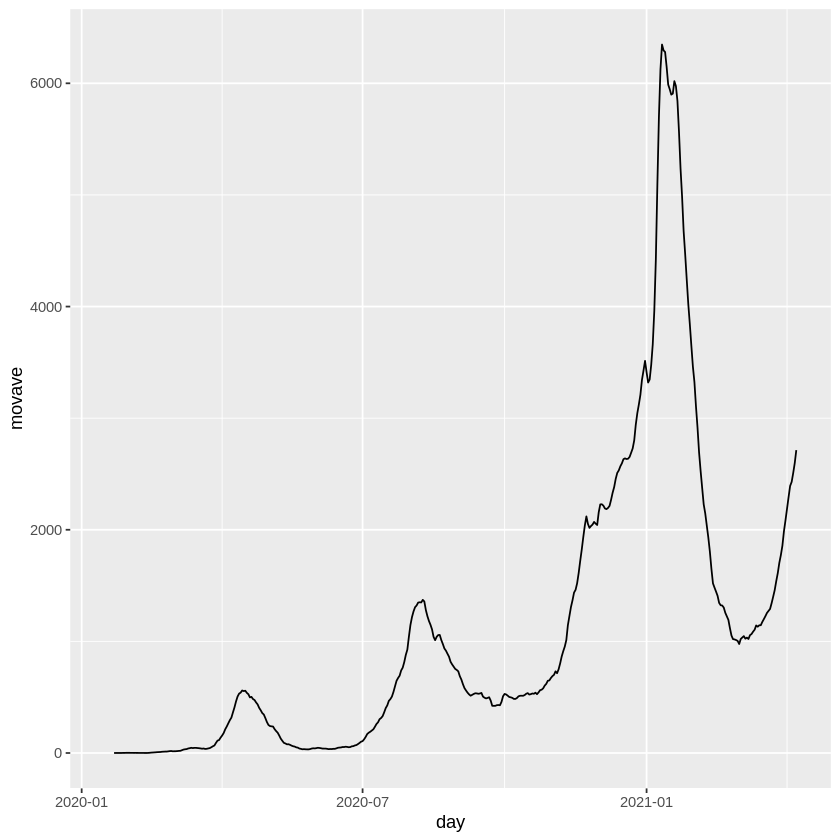

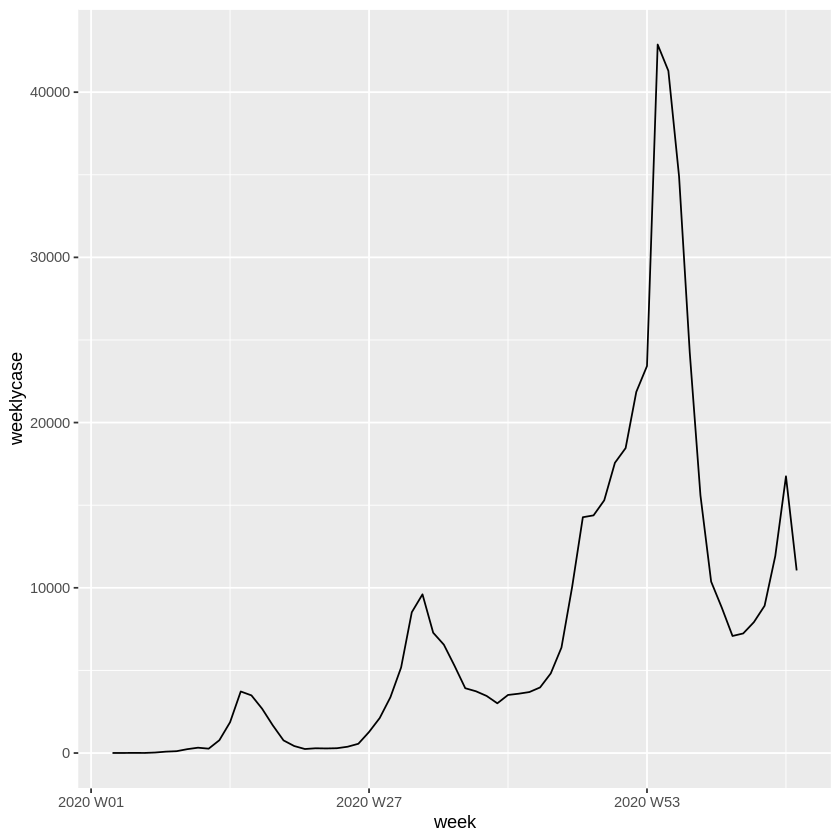

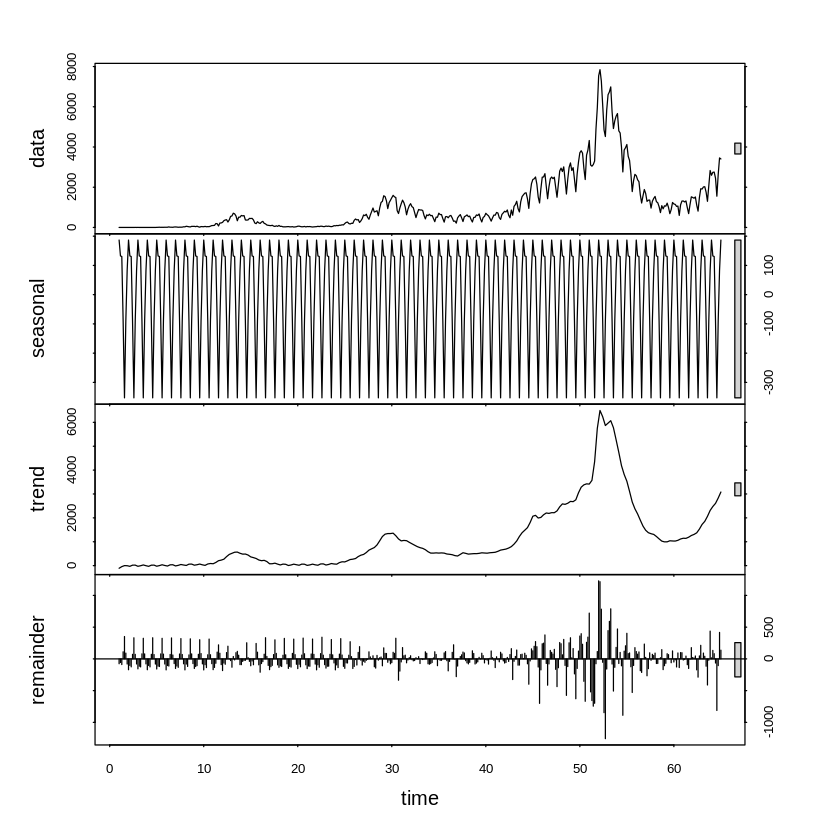


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : 6444.933
 ARIMA(1,1,0) with drift         : 6425.113
 ARIMA(0,1,1) with drift         : 6414.104
 ARIMA(0,1,0)                    : 6443.179
 ARIMA(1,1,1) with drift         : 6411.106
 ARIMA(2,1,1) with drift         : 6365.988
 ARIMA(2,1,0) with drift         : 6402.072
 ARIMA(3,1,1) with drift         : 6360.142
 ARIMA(3,1,0) with drift         : 6385.611
 ARIMA(4,1,1) with drift         : 6342.181
 ARIMA(4,1,0) with drift         : 6350.648
 ARIMA(5,1,1) with drift         : 6330.853
 ARIMA(5,1,0) with drift         : 6328.907
 ARIMA(5,1,0)                    : 6327.718
 ARIMA(4,1,0)                    : 6349.165
 ARIMA(5,1,1)                    : 6329.658
 ARIMA(4,1,1)                    : 6340.861

 Now re-fitting the best model(s) without approximations...

 ARIMA(5,1,0)                    : 6335.189

 Best model: ARIMA(5,1,0)                    

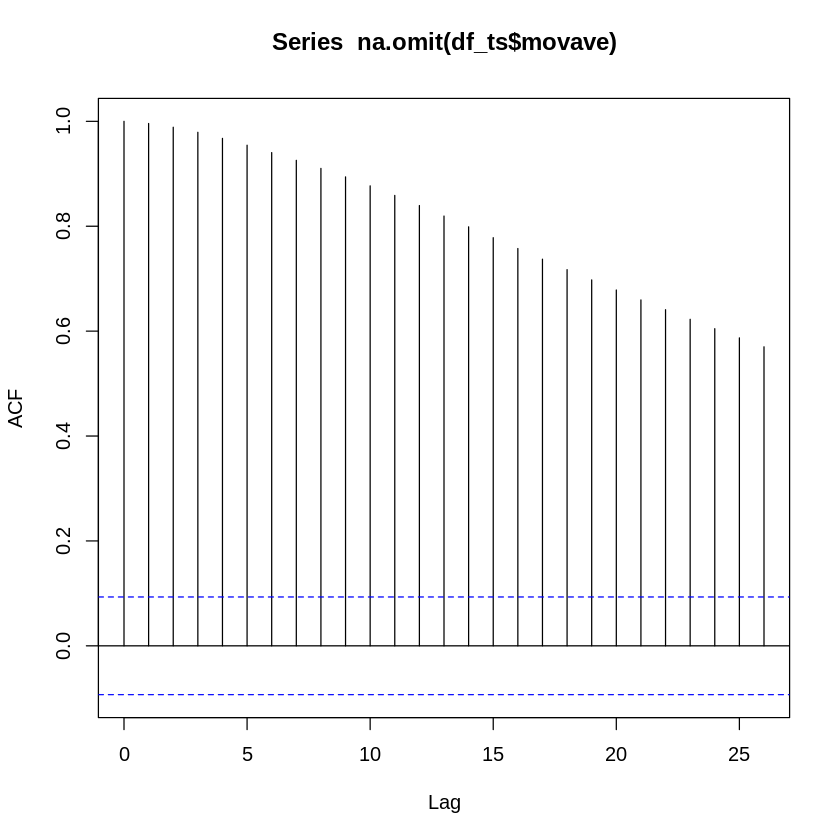

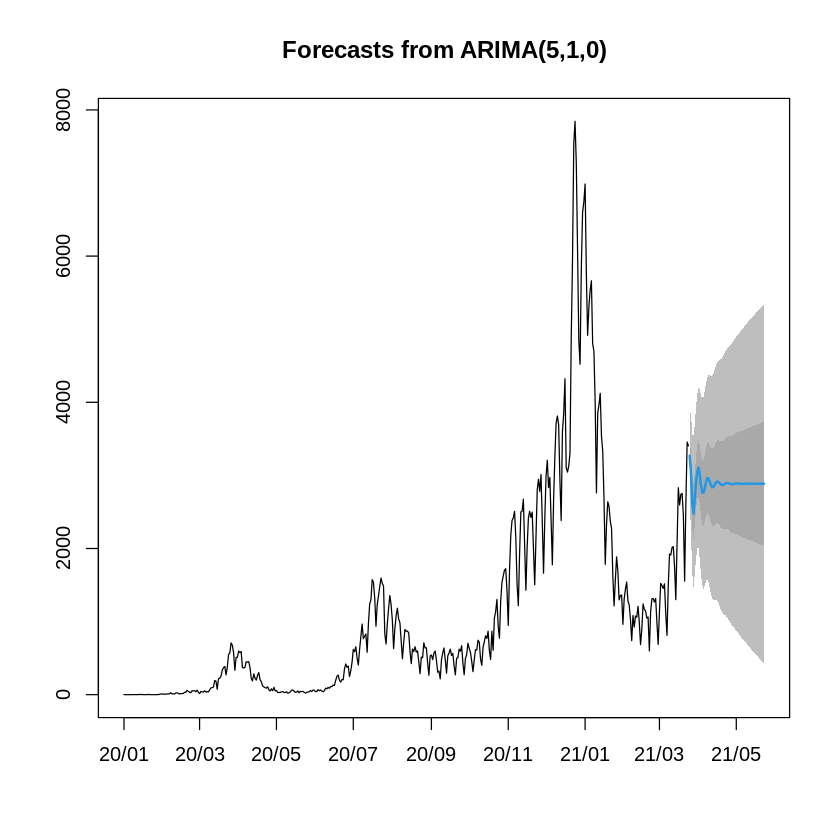

In [10]:
#厚生労働省「新型コロナウイルス感染症について 」オープンデータ
#https://www.mhlw.go.jp/stf/covid-19/open-data.html
d <- read.csv("https://www.mhlw.go.jp/content/pcr_positive_daily.csv", header=TRUE)

df <- data.frame(day = as.Date(d$日付), case = d$PCR.検査陽性者数.単日.)

#ライブラリの読み込み
library(tsibble)
library(dplyr)
library(ggplot2)
library(zoo)
library(forecast)

#作図
df %>% 
  as_tsibble　%>%　
  ggplot()　+ geom_line(aes(x = day, y = case))

#移動平均
df_ts <- df %>% 
  as_tsibble　%>%
  mutate(movave = zoo::rollmean(case, 7, align = "right", fill = NA)) 

df_ts %>%　
  ggplot()　+ geom_line(aes(x = day, y = movave))

#週毎に集計
  df %>% 
    as_tsibble　%>%
    mutate(week = yearweek(day))　%>%
    index_by(week) 　%>% 
    summarise(weeklycase = sum(case))  %>%　
    ggplot()　+ geom_line(aes(x = week, y = weeklycase))

#成分の分解
df$case %>% 
  ts(frequency=7) %>%
  stl(s.window="periodic") %>%
  plot()

#移動平均後の感染者数の自己相関関数
acf(na.omit(df_ts$movave))

#auto.arima()による予測
npred <- 60 #60日予測
dts <- ts(df$case, start=df$day[1])
fit <- auto.arima(dts, ic="aic", stepwise=T, trace=T) 
plot(forecast(fit, level = c(50,95), h =npred), shadecols=c("gray", "darkgray"),xaxt="n")
axis.Date(side=1,at=seq(from=min(df$day), to = max(df$day)+npred,by="2 months"),format="%y/%m")